In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.metrics import silhouette_score
from os import listdir, chdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
mypath = '../raccoon_proximity_weighted'
files = [mypath + '/' + f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [(int(f.split('_')[5].split('.')[0]), f) for f in files]
files.sort()
filt = [str(x) for x in range(16)]

In [14]:
def d_mat(g):
    A = nx.to_numpy_matrix(g)
    A = 1/(1+np.log(A + 1))
    np.fill_diagonal(A, 0)
    return A

def cluster_score(X, g):
    scores = []
    labels = []
    for i in range(2, len(X)):
        hierarchical_model = AC(n_clusters=i, affinity='precomputed', linkage='complete').fit(X)
        l = hierarchical_model.labels_
        s = silhouette_score(X, l, metric="precomputed")
        scores.append(s)
        labels.append(l)
    
    idx = np.argmax(scores)
    clust_lab = {list(g.nodes())[i]:list(labels[idx])[i] for i in range(len(labels[idx]))}
    return clust_lab, scores

clusters = []
for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    clusters.append(cluster_score(d_mat(G), G))

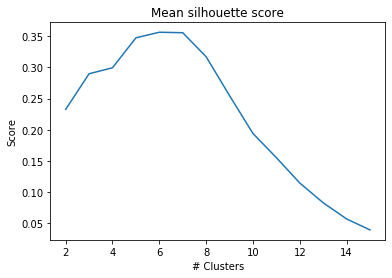

In [16]:
scores = {i:clusters[i][1] for i in range(len(clusters))}
for j in scores:
    scores[j] = {i:scores[j][i] for i in range(len(scores[j]))}
plt.plot(range(2, 16), pd.DataFrame(scores).mean(axis=1))
plt.title('Mean silhouette score')
plt.xlabel('# Clusters')
plt.ylabel('Score')
plt.show()

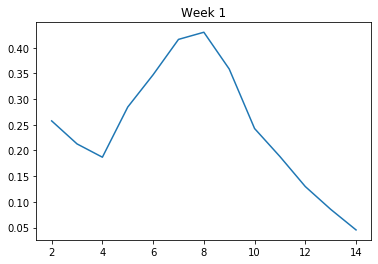

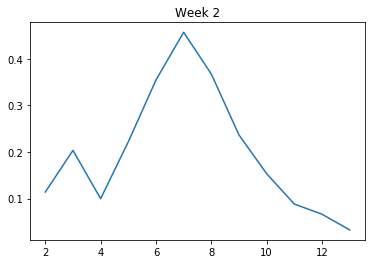

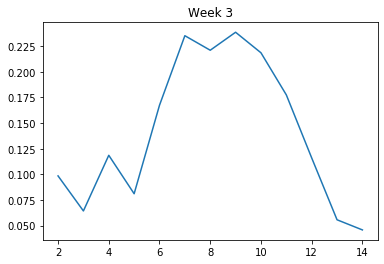

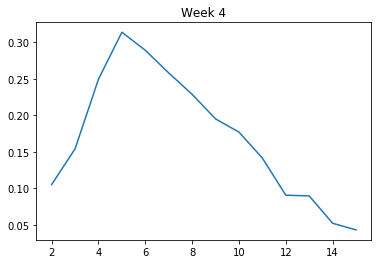

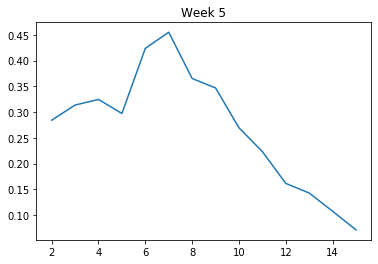

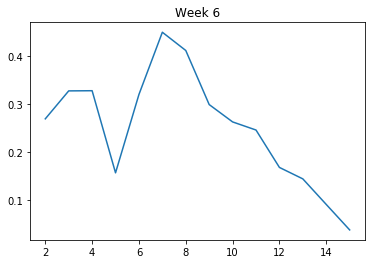

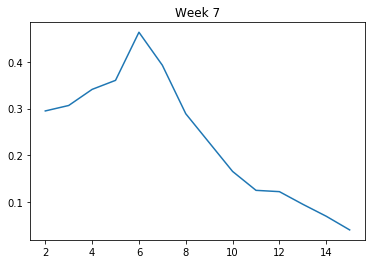

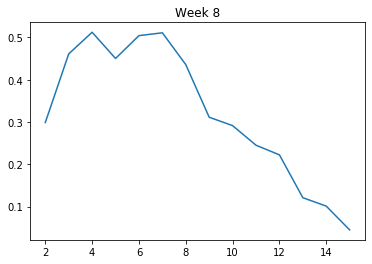

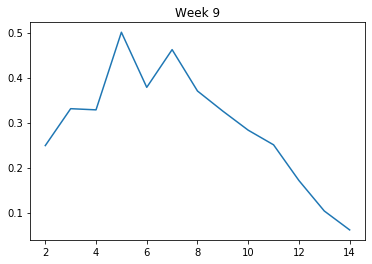

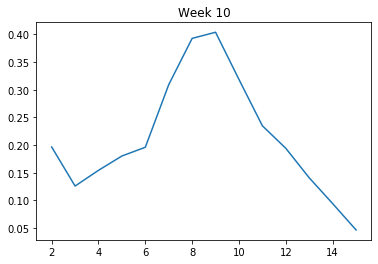

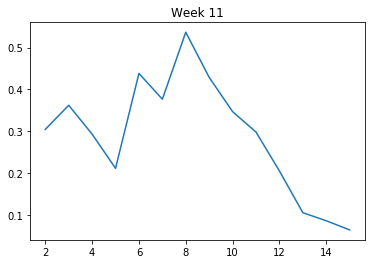

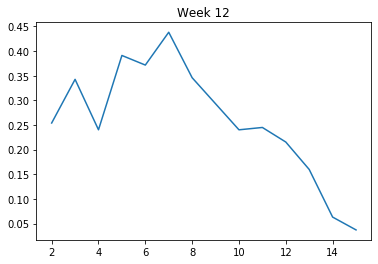

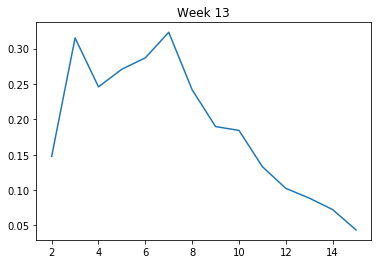

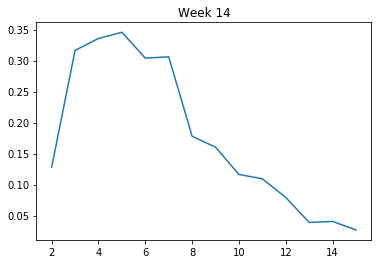

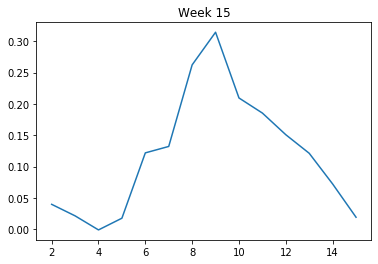

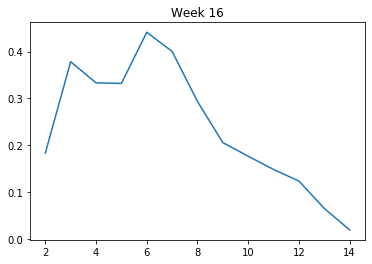

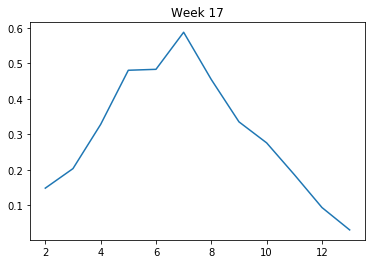

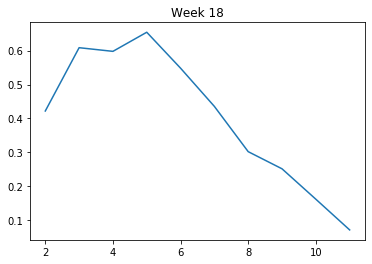

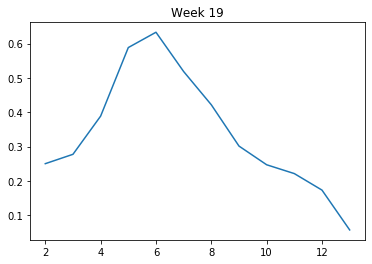

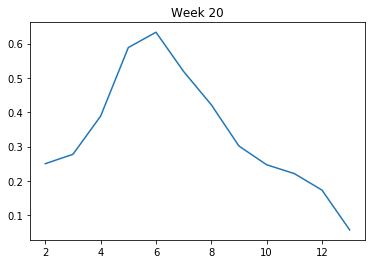

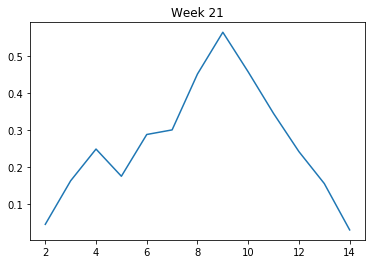

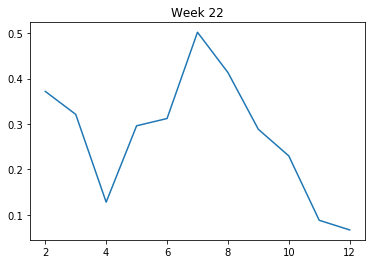

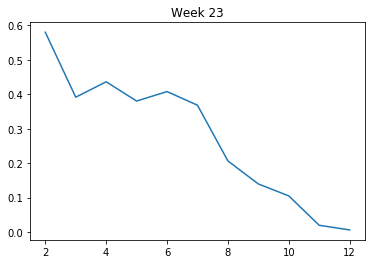

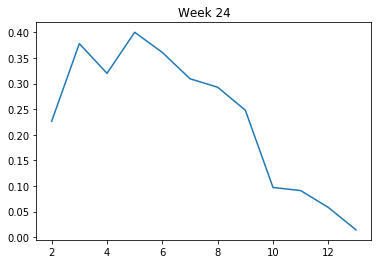

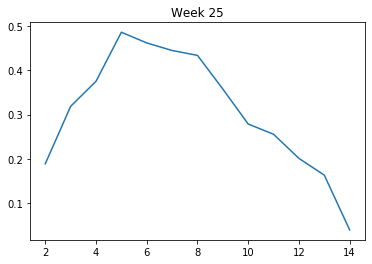

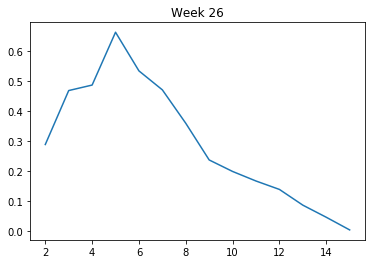

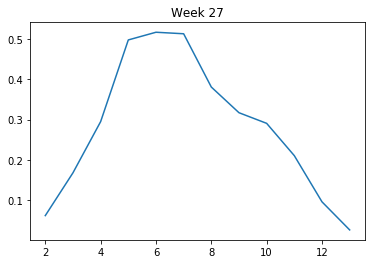

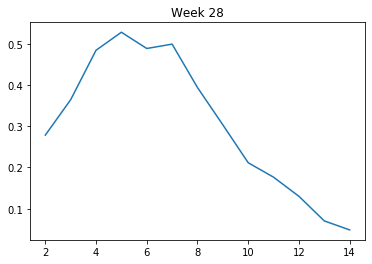

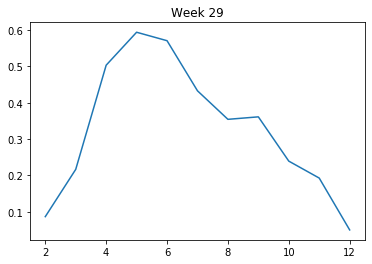

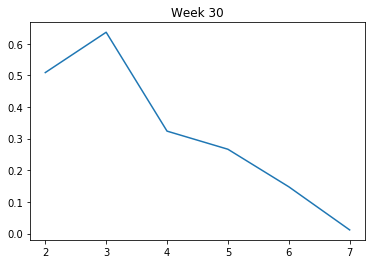

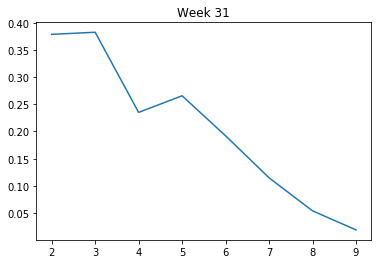

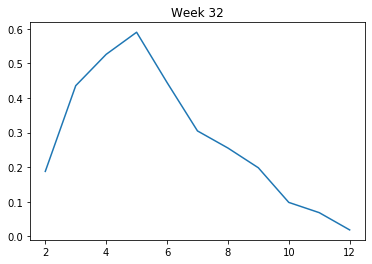

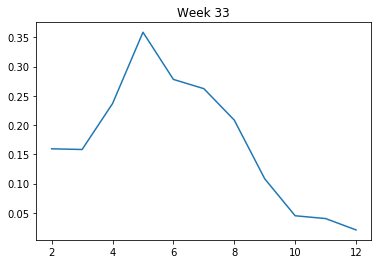

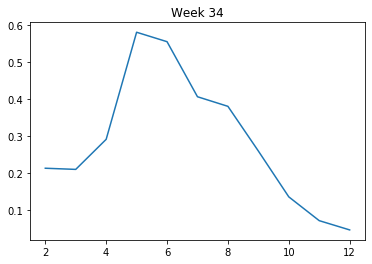

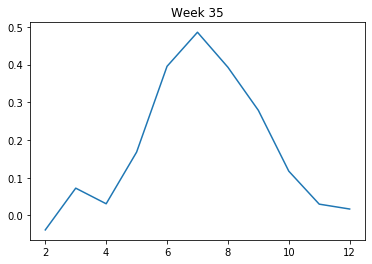

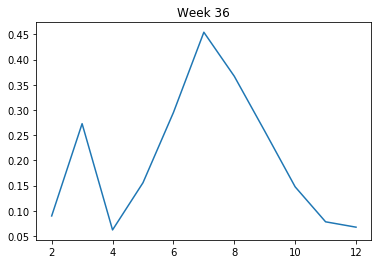

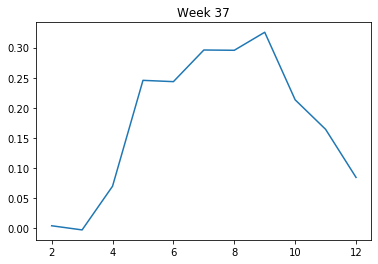

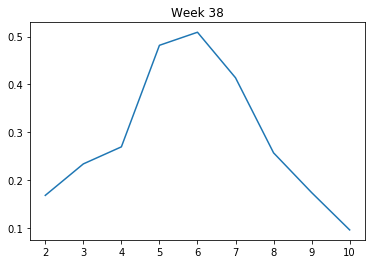

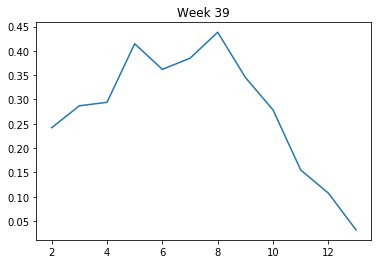

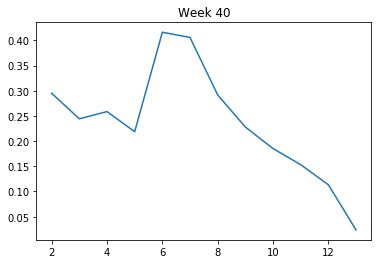

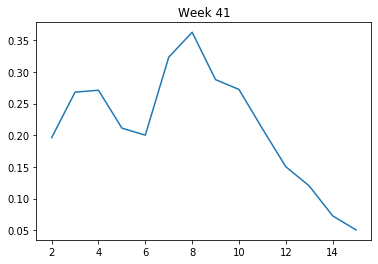

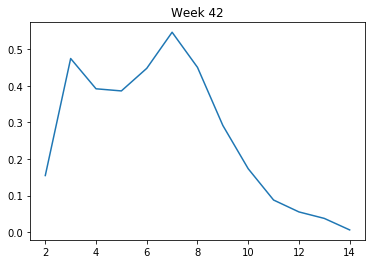

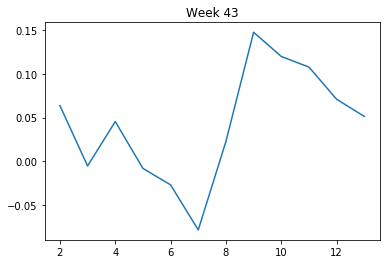

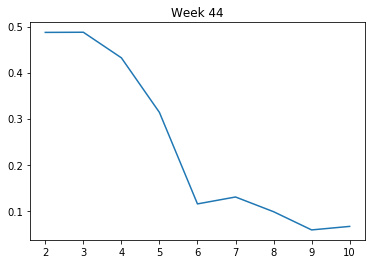

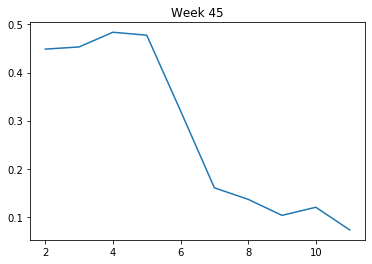

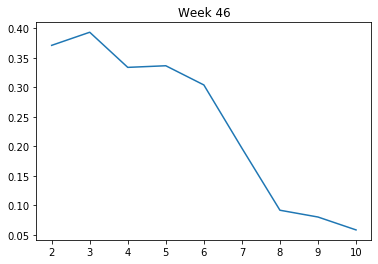

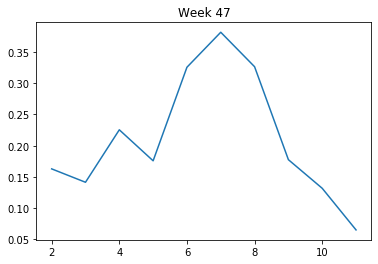

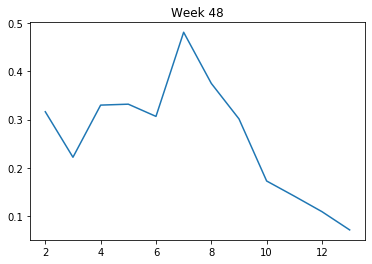

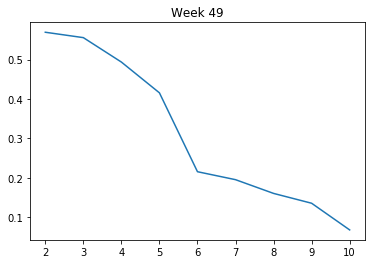

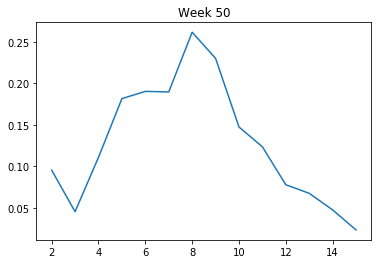

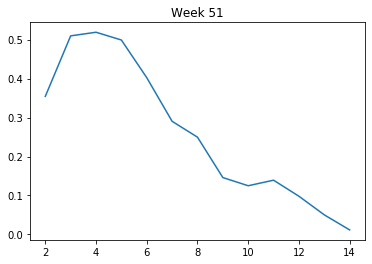

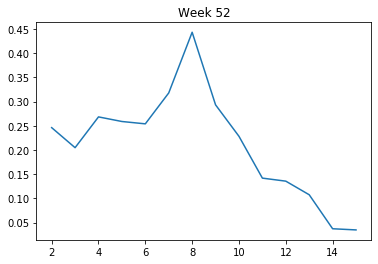

In [29]:
i=1
for s in scores:
    plt.plot(range(2, len(list(scores[s].values())) + 2), list(scores[s].values()))
    plt.title('Week ' + str(i))
    plt.show()
    i += 1

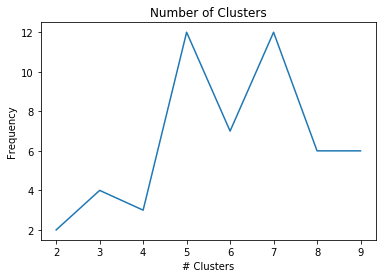

In [43]:
from collections import Counter
n_clust = [max(c[0].values()) + 1 for c in clusters]
n_clust = Counter(n_clust)
k = sorted(n_clust)
n_clust = [n_clust[x] for x in k]
plt.plot(k, n_clust)
plt.title('Number of Clusters')
plt.xlabel('# Clusters')
plt.ylabel('Frequency')
plt.show()

In [17]:
import plotly.graph_objects as go

final_pos = pd.read_csv('final_pos.csv', index_col='index')
final_pos.index = final_pos.index.map(str)
final_pos = dict(final_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

def create_edges(G, pos):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    return edge_trace

def create_nodes(G, pos):
    node_x = [-1]
    node_y = [-1]
    for p in pos.values():
        x, y = p
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(size=20,
            line_width=2))

    node_adjacencies = [-1]
    node_text = ['na']
    c, xx = cluster_score(d_mat(G), G)
    for k in pos.keys():
        if k in G.nodes:
            node_adjacencies.append(c[k])
            node_text.append('Cluster: '+str(c[k]))
        else:
            node_adjacencies.append(-1)
            node_text.append('Cluster: NA')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    return node_trace

In [18]:
weeks = list(range(1, 53))
x = [x[0] for x in final_pos.values()]
y = [x[1] for x in final_pos.values()]
# make figure
G = nx.read_graphml(files[0][1]).subgraph(filt)
fig_dict = {
    "data": [create_edges(G, final_pos), create_nodes(G, final_pos)],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]['title'] = '<br>Evolution of clusters through time'
fig_dict["layout"]['titlefont_size'] = 16
fig_dict["layout"]['showlegend'] = False
fig_dict["layout"]['hovermode'] = 'closest'
fig_dict["layout"]['margin'] = dict(b=20,l=5,r=5,t=40)
fig_dict["layout"]['xaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(x)*1.1, max(x)*1.1])
fig_dict["layout"]['yaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(y)*1.1, max(y)*1.1])

fig_dict["layout"]["sliders"] = {
    "args": [
        "transition", {
            "duration": 400,
            "easing": "cubic-in-out"
        }
    ],
    "initialValue": "1",
    "plotlycommand": "animate",
    "values": weeks,
    "visible": True
}
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#Update the data and frames

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    frame = {"data": [create_edges(G, final_pos), create_nodes(G, final_pos)], "name": f[0]}
    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [f[0]],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f[0],
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()